<a href="https://colab.research.google.com/github/1ayse/1ayse/blob/main/Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Upload file
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [3]:
# Read the data file
import pandas as pd
df = pd.read_excel("Online Retail.xlsx")

In [4]:
# Check first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Data Cleaning

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
# CohortMonth creation

df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'] \
                      .transform('min').dt.to_period('M')

df[['CustomerID','InvoiceDate','CohortMonth']].head()


,CustomerID,InvoiceDate,CohortMonth
0,17850.0,2010-12-01 08:26:00,2010-12
1,17850.0,2010-12-01 08:26:00,2010-12
2,17850.0,2010-12-01 08:26:00,2010-12
3,17850.0,2010-12-01 08:26:00,2010-12
4,17850.0,2010-12-01 08:26:00,2010-12


In [7]:
# Creating Index

df['CohortIndex'] = ((df['InvoiceDate'].dt.year - df['CohortMonth'].dt.year) * 12 +
                     (df['InvoiceDate'].dt.month - df['CohortMonth'].dt.month) + 1)

df[['CustomerID','InvoiceDate','CohortMonth','CohortIndex']].head()


,CustomerID,InvoiceDate,CohortMonth,CohortIndex
0,17850.0,2010-12-01 08:26:00,2010-12,1
1,17850.0,2010-12-01 08:26:00,2010-12,1
2,17850.0,2010-12-01 08:26:00,2010-12,1
3,17850.0,2010-12-01 08:26:00,2010-12,1
4,17850.0,2010-12-01 08:26:00,2010-12,1


In [8]:
# Cohort Table Creation

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'] \
                .nunique().reset_index()

# Pivot to get cohort counts table
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')

cohort_counts.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN


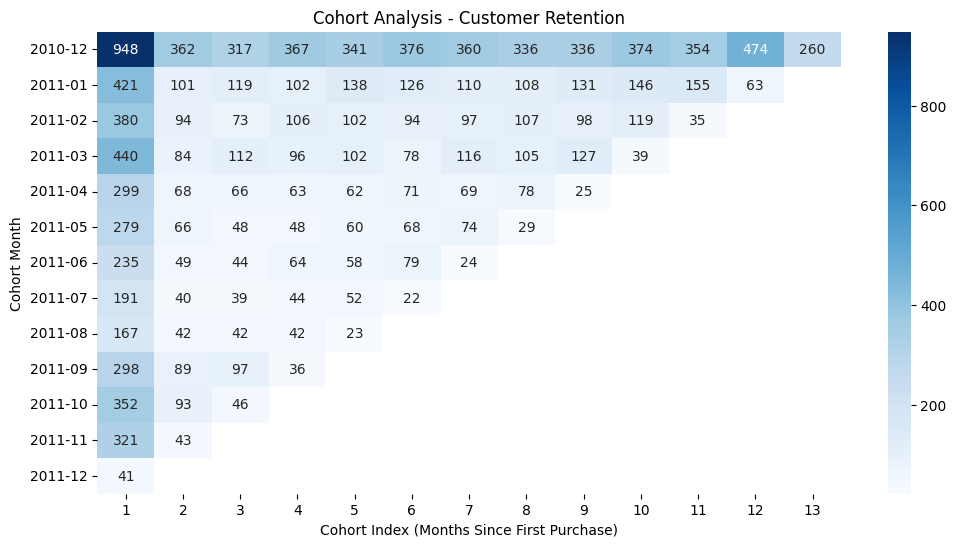

In [9]:
# Visualization : Heatmap

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(cohort_counts, annot=True, fmt='g', cmap="Blues")
plt.title("Cohort Analysis - Customer Retention")
plt.ylabel("Cohort Month")
plt.xlabel("Cohort Index (Months Since First Purchase)")
plt.show()


In [10]:
# How many customers made their first purchase in January 2011?

jan2011_customers = cohort_counts.loc['2011-01', 1]  # 1 = first month
print(f"Customers who made their first purchase in Jan 2011: {jan2011_customers}")


Customers who made their first purchase in Jan 2011: 421.0


In [13]:
# Customer Retention Rate


grouping = df.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)
print(retention)

CohortIndex   1         2         3         4         5         6         7   \
CohortMonth                                                                    
2010-12      1.0  0.381857  0.334388  0.387131  0.359705  0.396624  0.379747   
2011-01      1.0  0.239905  0.282660  0.242280  0.327791  0.299287  0.261283   
2011-02      1.0  0.247368  0.192105  0.278947  0.268421  0.247368  0.255263   
2011-03      1.0  0.190909  0.254545  0.218182  0.231818  0.177273  0.263636   
2011-04      1.0  0.227425  0.220736  0.210702  0.207358  0.237458  0.230769   
2011-05      1.0  0.236559  0.172043  0.172043  0.215054  0.243728  0.265233   
2011-06      1.0  0.208511  0.187234  0.272340  0.246809  0.336170  0.102128   
2011-07      1.0  0.209424  0.204188  0.230366  0.272251  0.115183       NaN   
2011-08      1.0  0.251497  0.251497  0.251497  0.137725       NaN       NaN   
2011-09      1.0  0.298658  0.325503  0.120805       NaN       NaN       NaN   
2011-10      1.0  0.264205  0.130682    

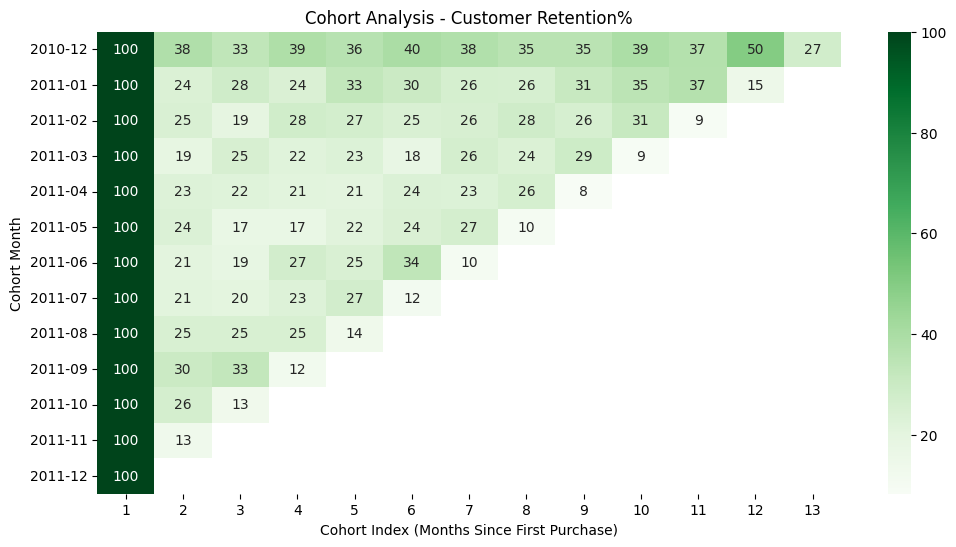

In [21]:
# Visualization of Retention Rate

plt.figure(figsize=(12,6))
sns.heatmap(retention*100, annot=True, fmt=".0f", cmap="Greens")
plt.title("Cohort Analysis - Customer Retention%")
plt.ylabel("Cohort Month")
plt.xlabel("Cohort Index (Months Since First Purchase)")
plt.show()


In [15]:
# Average Price Calculation

online = df.copy()

# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
print(average_price.round(1))

CohortIndex    1    2    3    4    5    6    7    8    9    10   11   12   13
CohortMonth                                                                  
2010-12       3.2  3.2  3.2  3.6  2.9  5.0  3.2  3.2  3.5  3.0  3.3  2.8  2.8
2011-01       3.5  3.7  3.1  8.4  3.2  3.2  2.9  2.7  2.6  5.5  2.9  2.6  NaN
2011-02       3.3  4.4  4.8  3.1  3.0  2.8  2.8  3.2  2.9  2.9  3.2  NaN  NaN
2011-03       3.3  5.0  3.7  3.3  3.6  2.8  2.8  2.8  2.7  2.5  NaN  NaN  NaN
2011-04       3.4  4.0  3.3  2.7  3.0  2.9  2.9  2.8  2.6  NaN  NaN  NaN  NaN
2011-05       4.6  3.2  2.6  3.2  2.7  2.5  2.6  2.5  NaN  NaN  NaN  NaN  NaN
2011-06      10.4  3.2  3.3  2.8  2.6  3.5  2.3  NaN  NaN  NaN  NaN  NaN  NaN
2011-07       4.5  3.5  2.7  2.7  2.4  2.4  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-08       3.0  5.4  5.7  7.0  6.8  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-09       3.2  3.6  2.9  2.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-10       4.0  2.7  2.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  